In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
%config InlineBackend.figure_formats = ['svg']

project_dir = '~/RL_2024/'

In [2]:
nS = 750
nA = 25

In [3]:
def make_policy(df_data):
    """
    Create behavior policy π_b from the dataset.
    """
    # count occurrences of each state-action pair
    SA_count = df_data.groupby(['s:state', 'a:action']).size() \
        .unstack().reindex(index=range(nS), columns=range(nA)).fillna(0)

    # behavior policy
    π_b = SA_count.div(SA_count.sum(axis=1), axis=0)

    # only allow actions frequently used by clinicians
    SA_mask = (SA_count > 5)

    # for states without any "available" actions, allow the most frequent action
    for s in range(nS-1):
        if SA_mask.loc[s].sum() == 0:
            SA_mask.loc[s, SA_count.loc[s].argmax()] = True

    return π_b, SA_mask, SA_count

In [4]:
df_train_orig = pd.read_csv(project_dir + 'data/trajectory_data/traj_orig_train.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
π_b_orig, SA_mask_orig, SA_count_orig = make_policy(df_train_orig)

In [5]:
df_train_dropped = pd.read_csv(project_dir + 'data/trajectory_data/traj_dropped_train.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
π_b_dropped, SA_mask_dropped, SA_count_dropped = make_policy(df_train_dropped)

In [6]:
df_train_shifted = pd.read_csv(project_dir + 'data/trajectory_data/traj_shifted_train.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
π_b_shifted, SA_mask_shifted, SA_count_shifted = make_policy(df_train_shifted)

In [7]:
π_b_orig.to_pickle(project_dir + 'data/behavior_policy/π_b_orig.pkl')
π_b_dropped.to_pickle(project_dir + 'data/behavior_policy/π_b_dropped.pkl')
π_b_shifted.to_pickle(project_dir + 'data/behavior_policy/π_b_shifted.pkl')

In [8]:
SA_mask_orig.to_pickle(project_dir + 'data/behavior_policy/SA_mask_orig.pkl')
SA_mask_dropped.to_pickle(project_dir + 'data/behavior_policy/SA_mask_dropped.pkl')
SA_mask_shifted.to_pickle(project_dir + 'data/behavior_policy/SA_mask_shifted.pkl')

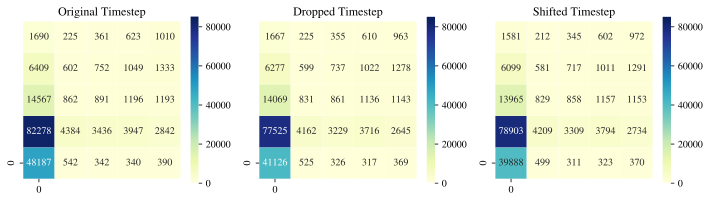

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

vmin, vmax = 0, 85000

ax = axes[0]
sns.heatmap(
    SA_count_orig.sum(axis=0).values.reshape((5,5)),
    square=True, cmap="YlGnBu", linewidths=.1, annot=True, fmt='g',
    xticklabels=5, yticklabels=5, ax=ax,
    vmin=vmin, vmax=vmax,
)
ax.invert_yaxis()
ax.set_title('Original Timestep')

ax = axes[1]
sns.heatmap(
    SA_count_dropped.sum(axis=0).values.reshape((5,5)),
    square=True, cmap="YlGnBu", linewidths=.1, annot=True, fmt='g',
    xticklabels=5, yticklabels=5, ax=ax,
    vmin=vmin, vmax=vmax,
)
ax.invert_yaxis()
ax.set_title('Dropped Timestep')

ax = axes[2]
sns.heatmap(
    SA_count_shifted.sum(axis=0).values.reshape((5,5)),
    square=True, cmap="YlGnBu", linewidths=.1, annot=True, fmt='g',
    xticklabels=5, yticklabels=5, ax=ax,
    vmin=vmin, vmax=vmax,
)
ax.invert_yaxis()
ax.set_title('Shifted Timestep')

plt.show()

## Comparisons

if consecutive actions are always the same, then discretizing time the wrong way doesn't matter.

In [10]:
# How often are actions of two consecutive steps the same?
print(
    (df_train_dropped['a:action'] == df_train_shifted['a:action']).mean(),
)

0.6937053821969308


In [11]:
# How often are the behavior policy action probabilities different?
print(
    (π_b_orig.values != π_b_dropped.values).mean(),
    (π_b_orig.values != π_b_shifted.values).mean(),
    (π_b_dropped.values != π_b_shifted.values).mean(),
)

0.5672 0.6556266666666667 0.5111466666666666


In [12]:
(π_b_shifted.values - π_b_orig.values).min(), (π_b_shifted.values - π_b_orig.values).max()

(np.float64(-0.30828055187312814), np.float64(0.12847608453837595))

Maximum absolute differences: 0.30828055187312814


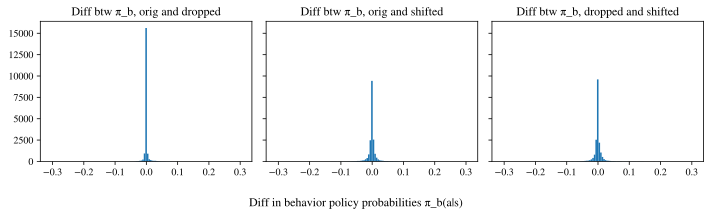

In [13]:
# pairwise differences in behavior policy

amax = np.max([
    np.abs(π_b_orig.values - π_b_dropped.values).max(), 
    np.abs(π_b_orig.values - π_b_shifted.values).max(),
    np.abs(π_b_dropped.values - π_b_shifted.values).max()
])

print("Maximum absolute differences:", amax)

fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)

plt.sca(ax[0])
plt.hist((π_b_orig.values - π_b_dropped.values).flatten(), bins=np.arange(-amax, amax, 0.005))
plt.title('Diff btw π_b, orig and dropped')

plt.sca(ax[1])
plt.hist((π_b_orig.values - π_b_shifted.values).flatten(), bins=np.arange(-amax, amax, 0.005))
plt.title('Diff btw π_b, orig and shifted')

plt.sca(ax[2])
plt.hist((π_b_dropped.values - π_b_shifted.values).flatten(), bins=np.arange(-amax, amax, 0.005))
plt.title('Diff btw π_b, dropped and shifted')

fig.supxlabel('Diff in behavior policy probabilities π_b(a|s)')
plt.tight_layout()

plt.show()

did the behavior policy change? changed slightly, tail of the distribution different, centered at zero but the prob mass shifted from some action to some other actions